# Download and organize ENCODE data

```bash
# Path data (TODO: change to the path you want to store the data in)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Download reference genome from ENCODE
wget https://www.encodeproject.org/files/GRCh38_no_alt_analysis_set_GCA_000001405.15/@@download/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz -O $path_data/hg38.fa.gz
gunzip $path_data/hg38.fa.gz

# Download reference chromosome sizes from ENCODE
wget https://www.encodeproject.org/files/GRCh38_EBV.chrom.sizes/@@download/GRCh38_EBV.chrom.sizes.tsv -O $path_data/hg38.chrom.sizes

# Download reference blacklist regions from ENCODE
wget https://www.encodeproject.org/files/ENCFF356LFX/@@download/ENCFF356LFX.bed.gz -O $path_data/blacklist.bed.gz
gunzip $path_data/blacklist.bed.gz

# download K562 ENCODE ATAC-seq peaks from ENCODE
wget https://www.encodeproject.org/files/ENCFF333TAT/@@download/ENCFF333TAT.bed.gz -O $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed.gz
gunzip $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed.gz

# download K562 ENCODE ATAC-seq bam for reps 1, 2, 3 from ENCODE
wget https://www.encodeproject.org/files/ENCFF077FBI/@@download/ENCFF077FBI.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep1.bam
wget https://www.encodeproject.org/files/ENCFF128WZG/@@download/ENCFF128WZG.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep2.bam
wget https://www.encodeproject.org/files/ENCFF534DCE/@@download/ENCFF534DCE.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep3.bam
```

# Create BigWig files w/ `chrombpnet`

```bash
# Path data (TODO: change to the path set above)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Merge and sort bam files
samtools merge -f $path_data/merged_unsorted.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep1.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep2.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep3.bam
samtools sort -@4 $path_data/merged_unsorted.bam -o $path_data/merged.bam
samtools index $path_data/merged.bam

# use chrombpnet to get unstranded counts bigwig with correct shift (+4/-4)
script=/cellar/users/aklie/opt/chrombpnet/chrombpnet/helpers/preprocessing/reads_to_bigwig.py
cmd="python $script \
--genome $path_data/hg38.fa \
--input-bam-file $path_data/merged.bam \
--chrom-sizes $path_data/hg38.chrom.sizes \
--output-prefix $path_data/K562_ATAC-seq_merged \
--data-type ATAC"
echo $cmd
eval $cmd

# clean up intermediate files and rename K562_ATAC-seq_merged_unstranded.bw to K562_ATAC-seq_unstranded_counts.bw
mv $path_data/K562_ATAC-seq_merged_unstranded.bw $path_data/K562_ATAC-seq_unstranded_counts.bw 
rm $path_data/merged_unsorted.bam $path_data/merged.bam
```

# Get GC matched negatives with `tangermeme`

```bash
# Path data (TODO: change to the path set above)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Get GC matched negatives
cmd="bpnet negatives \
-i $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed \
-f $path_data/hg38.fa \
-b $path_data/blacklist.bed \
-o $path_data/K562_ATAC-seq_negatives.bed"
-l 0.02 \
-w 2114 \
-v
echo $cmd
eval $cmd

# Make version of negatives with distance to center for chrombpnet
awk '{mid = int(($2 + $3) / 2); distance = mid - $2; print $0, ".", ".", ".", ".", ".", ".", distance}' $path_data/K562_ATAC-seq_negatives.bed > $path_data/K562_ATAC-seq_negatives.chrombpnet.bed
```

# Make SeqDatas w/ `seqdata`

In [ ]:
# Imports
import os
import numpy as np
import seqdata as sd
import xarray as xr

In [2]:
# TODO: change to your path
data_dir = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data"

In [ ]:
# Set-up all file paths
peaks = os.path.join(data_dir, "ENCSR868FGK_K562_ATAC-seq_peaks.bed")
negatives = os.path.join(data_dir, "K562_ATAC-seq_negatives.bed")
signal = os.path.join(data_dir, "K562_ATAC-seq_unstranded_counts.bw")
fasta = os.path.join(data_dir, "hg38.fa")
peaks, negatives, signal

In [ ]:
# Make output directory if doesn't exist
peaks_out = os.path.join(data_dir, "K562_ATAC-seq_peaks.zarr")
negatives_out = os.path.join(data_dir, "K562_ATAC-seq_negatives.zarr")
out = os.path.join(data_dir, "K562_ATAC-seq.zarr")
peaks_out, negatives_out

In [ ]:
# Build SeqData peaks
sdata_peaks = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["K562_ATAC-seq"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=peaks_out,
    fixed_length=2114,
    bed=peaks,
    overwrite=True,
    max_jitter=128
)
sdata_peaks["type"] = "peak"
sdata_peaks.load()

In [ ]:
# Build SeqData from negatives
sdata_neg = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["K562_ATAC-seq"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=negatives_out,
    fixed_length=2114,
    bed=negatives,
    overwrite=True,
    max_jitter=128
)
sdata_neg["type"] = "negative"
sdata_neg.load()

In [ ]:
# Concatenate the two datasets
sdata = xr.concat([sdata_peaks, sdata_neg], dim="_sequence")
# https://github.com/pydata/xarray/issues/3476#issuecomment-1115045538
for v in list(sdata.coords.keys()):
    if sdata.coords[v].dtype == object:
        sdata.coords[v] = sdata.coords[v].astype("unicode")
for v in list(sdata.variables.keys()):
    if sdata[v].dtype == object:
        sdata[v] = sdata[v].astype("unicode")
sdata.to_zarr(out, mode='w')
sdata

# Check against `pyBigWig`

In [17]:
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [18]:
# The actual BigWig file
file = pyBigWig.open(str(signal))

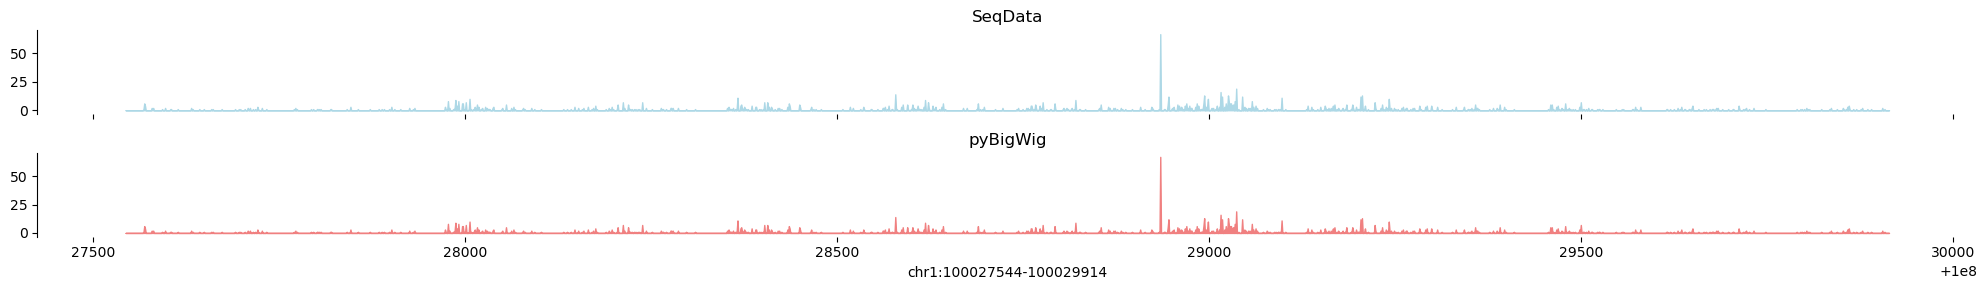

: 

In [26]:
# Get data
seq_num = 0
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
sdata_vals = sdata["cov"][seq_num].values.squeeze()
pybw_vals = np.nan_to_num(np.array(file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"])))
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "SeqData": sdata_vals,
    "pyBigWig": pybw_vals
}
colors = {
    "SeqData": "lightblue",
    "pyBigWig": "lightcoral"
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)

# DONE!

---

# Make SeqDataset

In [23]:
path_bw = sd.datasets.K562_ATAC_seq(type="bigwig")
path_bw

PosixPath('/cellar/users/aklie/.cache/seqdata/signal.bw')

In [24]:
path_seqdata = sd.datasets.K562_ATAC_seq(type="seqdata")
path_seqdata